<a href="https://colab.research.google.com/github/snghynn/stat_programming/blob/main/stat_programming_3_Pytorch_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ISLP

In [ ]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In [ ]:
import ISLP
import numpy as np
import pandas as pd
# from matplotlib.pyplot import subplots

# import statsmodels.api as sm

# Exercise 1.1:

Do the estimatsion procedure using `torch.nn.Linear(1,1, bias=True)`. Answer the following questions.





In [ ]:
Boston = load_data("Boston")
Boston.columns # 보스턴 데이터의 column 확인

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [ ]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
y = Boston['medv']
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [ ]:
# standardization
lstat_mean = np.mean(X["lstat"]) # 'lstat' 열의 평균을 계산하여 lstat_mean 변수에 저장
lstat_std = np.std(X["lstat"]) # 'lstat' 열의 표준편차를 계산하여 lstat_std 변수에 저장
X["lstat"] = ( X["lstat"]- lstat_mean) / lstat_std # 'lstat' 열의 각 요소를 평균에서 뺀 후 표준편차로 나누어 표준화
X

,intercept,lstat
0,1.0,-1.075562
1,1.0,-0.492439
2,1.0,-1.208727
3,1.0,-1.361517
4,1.0,-1.026501
...,...,...
501,1.0,-0.418147
502,1.0,-0.500850
503,1.0,-0.983048
504,1.0,-0.865302


In [ ]:
X_boston = X.copy() # 원본 데이터를 유지하기 위해 copy() 사용

In [ ]:
# Dataset and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim

In [ ]:
X_boston.columns # X값에 대한 column 확인

Index(['intercept', 'lstat'], dtype='object')

In [ ]:
Y = torch.tensor(y).reshape(-1,1) # NumPy 배열 y를 PyTorch 텐서로 변환하고 열 벡터 형태로 재구성
X = torch.tensor(X_boston.lstat).reshape(-1,1) # 데이터프레임 X_boston의 lstat 열을 PyTorch 텐서로 변환하고 열 벡터 형태로 재구성
X_tmp = X.type(torch.FloatTensor) # X 텐서를 데이터 타입을 FloatTensor로 변경하여 X_tmp에 저장
Y_tmp = Y.type(torch.FloatTensor) # Y 텐서를 데이터 타입을 FloatTensor로 변경하여 Y_tmp에 저장

In [ ]:
X.dtype # 현재 X.dtype이 float64임

torch.float64

In [ ]:
X_tmp.dtype # model의 coeff type이 float32이므로 맞춰줘야함

torch.float32

In [ ]:
dataset1 = TensorDataset(X_tmp,Y_tmp) # tmp 데이터들을 이용해 데이터셋 생성
trainloader = DataLoader(dataset = dataset1, batch_size = 5, shuffle = True)

dataset2 = TensorDataset(X,Y) # X,Y 이용해 데이터셋 생성
trainloader2 = DataLoader(dataset = dataset2, batch_size = 5, shuffle = True)

#### [1] model 정의  
* torch.nn.Linear = X$\cdot$beta와 같음.   
이때, X는 X variable로만 이뤄져 있으며, bias가 주여지면 X*beta + coeff로, design matrix를 이용한 linear model과 같음을 알 수 있음  

In [ ]:
model = torch.nn.Linear(1,1, bias = True)
#model.weight.type()를 하면 기본 내장은 floatTensor임

In [ ]:
model.weight.dtype # float32 type을 지님

torch.float32

In [ ]:
# criterion의 optimizer 설정
def criterion(yhat, y):
    return torch.mean((yhat-y)**2) # criterion함수는 예측값 (yhat)과 실제 값 (y) 간의 평균 제곱 오차(Mean Squared Error)를 계산

# my_optim: SGD 최적화기 설정. 파라미터를 최적화 대상은 'model'임
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01) # weight = weight - lr * weight.grd와 같음 즉 betas를 업데이트하는 식

In [ ]:
from tqdm import tqdm

In [ ]:
# 모델 학습: 특정 epoch동안 반복하여 모델을 학습하고 손실(LOSS) 값을 기록
epochs = 100 # 총 에폭 수를 100으로 설정
history = [] # 학습 과정에서 손실 값을 저장할 빈 리스트 'history' 생성
n = len(X) # 데이터의 전체 샘플 수를 'n'에 저장

for epoch in tqdm(range(epochs)): # 주어진 에폭 수(100 에폭) 동안 반복
    LOSS_sum = 0  # 각 에폭마다 새로운 에폭을 시작할 때 손실을 저장할 변수 LOSS_sum 초기화
    for xx, yy in trainloader: # 'trainloader'에서 미니배치 데이터 가져와서 반복
        yhat = model(xx) # 모델을 사용하여 입력 데이터 xx로부터 예측값 yhat을 계산
        loss = criterion(yhat, yy) # criterion을 사용하여 예측값(yhat)과 실제 값(yy) 간의 손실을 계산
        LOSS_sum = LOSS_sum + loss * len(yy) # 현재 미니배치에 대한 손실을 LOSS_sum에 더함. 손실 값은 미니배치 크기로 가중 평균되어 계산
        loss.backward() # 역전파를 수행하여 손실에 대한 gradient 계산
        my_optim.step() # optimizer 사용하여 모델의 가중치 업데이트
        my_optim.zero_grad() # 모델의 그래디언트를 초기화하여 다음 미니배치에 대한 그래디언트를 계산 준비
    history.append(LOSS_sum.item()/n) # 현재 에폭에서의 손실 값을 전체 데이터 포인트 수 n으로 나누어 평균 손실을 계산하고, 'history' 리스트에 추가

100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


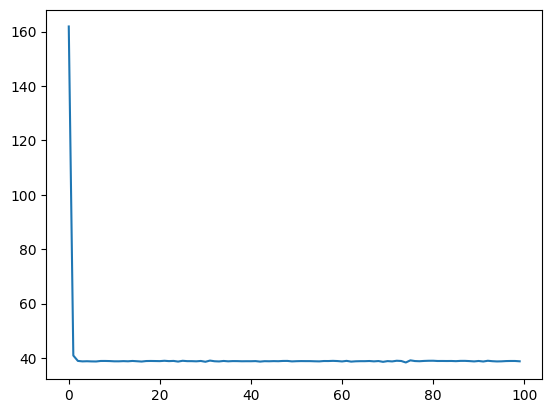

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.


In [ ]:
# lstat = 5
# lstat_value를 표준화하여 새로운 입력 데이터 X_new를 생성
X_new = torch.tensor((5-Boston['lstat'].mean())/Boston['lstat'].std(), dtype = torch.float32).reshape(-1,1)
Yhat_5 = model(X_new)
Yhat_5

tensor([[30.1203]], grad_fn=<AddmmBackward0>)

In [ ]:
# lstat = 10
# lstat_value를 표준화하여 새로운 입력 데이터 X_new를 생성
X_new = torch.tensor((10-Boston['lstat'].mean())/Boston['lstat'].std(), dtype = torch.float32).reshape(-1,1)
Yhat_10 = model(X_new)
Yhat_10

tensor([[25.2020]], grad_fn=<AddmmBackward0>)

In [ ]:
# lstat = 15
# lstat_value를 표준화하여 새로운 입력 데이터 X_new를 생성
X_new = torch.tensor((15-Boston['lstat'].mean())/Boston['lstat'].std(), dtype = torch.float32).reshape(-1,1)
Yhat_15 = model(X_new)
Yhat_15

tensor([[20.2837]], grad_fn=<AddmmBackward0>)


ii. Calculate $R^2$.


In [ ]:
def r2(y, yhat):
    # SST (Total Sum of Squares) 계산
    SST = sum((y - y.mean())**2)
    # 실제 값 y와 실제 값의 평균과의 차이의 제곱을 모두 합하여 SST 계산

    SSE = sum((y - yhat)**2)
    # 예측값 yhat와 실제 값 y 간의 차이의 제곱을 모두 합하여 SSE 계산

    # R2 값 계산하여 반환
    return 1 - SSE / SST
    # R2는 1에서 (SSE / SST)를 뺀 값으로 계산되며, 두 값의 비율을 이용하여 모델의 설명력을 측정

In [ ]:
Yhat = model(X_tmp)  # 입력 데이터 X_tmp로부터 예측값 Yhat을 계산
r2(Y, Yhat)  # 계산된 예측값 Yhat과 실제 값 Y를 사용하여 R2 값을 계산

tensor([0.5434], dtype=torch.float64, grad_fn=<RsubBackward1>)

# Exercise 1.2:

Do the estimatsion procedure using `torch.nn.Linear(2,1, bias=False)`.Answer the following questions.



In [ ]:
# 입력 데이터와 목표 변수를 PyTorch 텐서로 변환
Y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # y를 PyTorch float32 데이터 타입으로 변환하고 열 벡터 형태로 재구성

# design matrix 생성, X_design의 데이터 타입을 model의 dtype과 일치하도록 변경
X_design = torch.stack([torch.tensor(X_boston.intercept), torch.tensor(X_boston.lstat)], axis=1).type(torch.FloatTensor)
# X_design을 생성하고, 'X_boston.intercept'와 'X_boston.lstat'를 열(column)로 쌓아주며, 데이터 타입을 'torch.FloatTensor'로 변경

In [ ]:
X_design[:5,:] # 잘 변경되었다

tensor([[ 1.0000, -1.0756],
        [ 1.0000, -0.4924],
        [ 1.0000, -1.2087],
        [ 1.0000, -1.3615],
        [ 1.0000, -1.0265]])

In [ ]:
# stack으로 torch 값으로 쌓여있음을 알 수 있음.
print(X_design[:5])
print(X_boston.head())

tensor([[ 1.0000, -1.0756],
        [ 1.0000, -0.4924],
        [ 1.0000, -1.2087],
        [ 1.0000, -1.3615],
        [ 1.0000, -1.0265]])
   intercept     lstat
0        1.0 -1.075562
1        1.0 -0.492439
2        1.0 -1.208727
3        1.0 -1.361517
4        1.0 -1.026501


In [ ]:
dataset = TensorDataset(X_design,Y) # X_design과 Y로 구성된 dataset 생성
trainloader = DataLoader( dataset = dataset, batch_size = 5, shuffle = True) # 배치 크기를 5로 설정하며 데이터를 shuffle해 'trainloader'를 생성

In [ ]:
# 모델 생성
model = torch.nn.Linear(2,1, bias= False) # 입력 특성 수가 2, 출력 특성 수가 1인 선형 모델을 생성
my_optim_nonbias = torch.optim.SGD(model.parameters(), lr = 0.01) # 모델의 파라미터를 최적화하기 위해 SGD 옵티마이저 생성

# 모델 훈련
epochs = 100
n = len(X_design) # 입력 데이터 'X_design'의 길이를 'n'에 저장
history = [] # 훈련 과정에서 손실값을 저장할 리스트 'history' 생성


for _ in tqdm(range(epochs)):
    LOSS_sum = 0 # 각 에폭마다 손실값을 합산할 변수 'LOSS_sum' 초기화
    for xx, yy in trainloader: # 모델을 사용하여 예측값 'yhat' 계산
        yhat = model(xx) # 모델을 사용하여 예측값 'yhat' 계산
        loss = criterion(yhat, yy) # 손실 함수를 사용하여 손실값 'loss' 계산
        LOSS_sum = LOSS_sum + loss * len(yy) # 손실값을 누적하여 'LOSS_sum' 업데이트
        loss.backward() # 최적화 함수에 따른 grad계산

        my_optim_nonbias.step() # weight = weight -lr*weight.grad 계산
        my_optim_nonbias.zero_grad() # 최적화함수 미분식에 대한 grad update가 쌓이지 않도록 지워줌
    history.append(LOSS_sum.item()/n) # 현재 에폭에서의 평균 손실값을 history 리스트에 추가

100%|██████████| 100/100 [00:11<00:00,  8.33it/s]


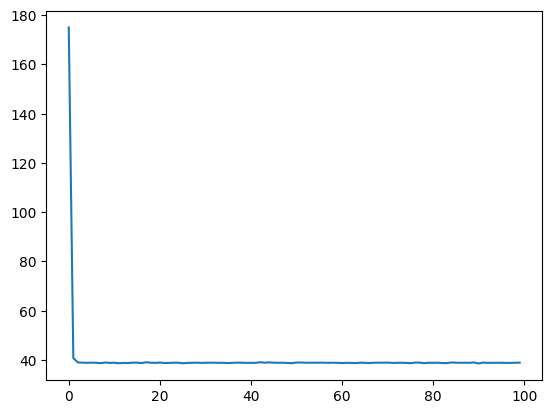

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.


In [ ]:
lstat_values = [5, 10, 15]

# lstat_values를 PyTorch 텐서로 변환
lstat_tensor = torch.tensor(lstat_values, dtype=torch.float32).reshape(-1, 1)
# 'lstat_values' 리스트를 PyTorch 텐서로 변환하며, 데이터 타입을 float32로 설정하고 열 벡터 형태로 재구성

# lstat 값을 입력으로 하는 특성 행렬 X를 생성 (상수 항 포함)
X_lstat = torch.cat((lstat_tensor, torch.ones(len(lstat_tensor), 1)), dim=1)
# 'lstat_tensor'와 상수 1로 구성된 열 벡터를 가로로 연결하여 특성 행렬 'X_lstat'을 생성

# 예측값 Ŷ 계산
with torch.no_grad():
    y_pred = model(X_lstat)
# 모델을 사용하여 'X_lstat'에 대한 예측값 계산. 'torch.no_grad()'를 사용하여 역전파가 일어나지 않도록 설정


# 예측값을 NumPy 배열로 변환
y_pred = y_pred.numpy()

# 주어진 lstat 값에 대한 예측값 출력
for lstat, y_hat in zip(lstat_values, y_pred):
    print("lstat=", lstat, "Ŷ=", y_hat[0])

lstat= 5 Ŷ= 105.51017
lstat= 10 Ŷ= 217.70953
lstat= 15 Ŷ= 329.90887



ii. Calculate $R^2$.


In [ ]:
# 앞에서 만든 r2 함수 사용하여 X_design에 대한 r2값 계산
Yhat = model(X_design)
r2(Y, Yhat)

tensor([0.5440], grad_fn=<RsubBackward1>)

# Exercise 1.3:

Do the estimatsion procedure using `torch.nn.Linear(1,1, bias=False)` and an additional bias parameter defined by `torch.tensor`. Model itself should be the same as in Exercise 1.1 and 1.2. (Caution: However, the estimated parameter(s) should not be the exactly the same due to the randomness in the parameter initialization and batch learning.)

Answer the following questions.




In [ ]:
Y = torch.tensor(y,dtype = torch.float32).reshape(-1,1)
X = torch.tensor(X_boston.lstat, dtype = torch.float32).reshape(-1,1) # 문제에서 주어진 것과 같은 조건

dataset1 = TensorDataset(X,Y) # tensordataset을 X, Y 이용해 생성
trainloader = DataLoader(dataset = dataset1, batch_size = 5, shuffle = True)

In [ ]:
model = torch.nn.Linear(1,1, bias = False)
# intercept 추가
beta0 = torch.tensor(torch.randn([1]),requires_grad=True)

# 학습 설정
epochs = 100  # 학습 에폭 횟수
history = []  # 손실 이력을 저장할 리스트
n = len(X)  # 데이터 샘플 수
lr = 0.01  # 학습률

for epoch in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader: # 미니배치 단위로 데이터를 가져와서 학습
        yhat = model(xx) + beta0 # 모델을 사용하여 예측값을 계산하고 절편을 더함
        loss = criterion(yhat, yy) # 손실 함수를 사용하여 손실을 계산
        LOSS_sum = LOSS_sum + loss * len(yy) # 손실을 누적

        loss.backward() # 그래디언트 계산
        # 모델 가중치 업데이트
        model.weight.data -= lr * model.weight.grad # my_optim.step()과 같은 결과
        beta0.data -= lr * beta0.grad
        # 그래디언트 초기화
        model.weight.grad = None # 모델 가중치의 그래디언트를 초기화
        beta0.grad = None # 절편의 그래디언트를 초기화

    history.append(LOSS_sum.item()/n) # 에폭별 평균 손실을 history에 추가

<ipython-input-34-52e788fcf46b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta0 = torch.tensor(torch.randn([1]),requires_grad=True)
100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


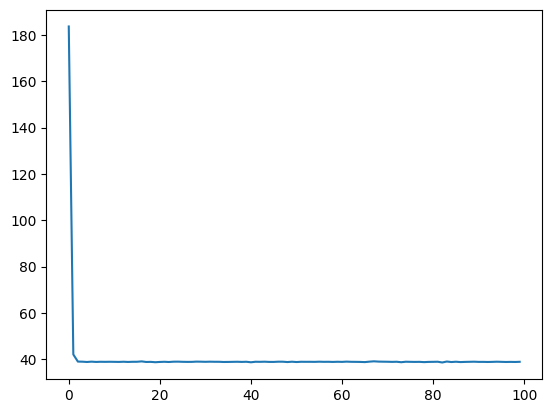

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

In [ ]:
# lstat = 5
# lstat_value를 표준화하여 새로운 입력 데이터 X_new를 생성
X_new = torch.tensor((5-Boston['lstat'].mean())/Boston['lstat'].std(), dtype = torch.float32).reshape(-1,1)
Yhat_5 = model(X_new) # lstat=5에 대한 모델학습
Yhat_5

tensor([[7.3189]], grad_fn=<MmBackward0>)

In [ ]:
# lstat = 10
# lstat_value를 표준화하여 새로운 입력 데이터 X_new를 생성
X_new = torch.tensor((10-Boston['lstat'].mean())/Boston['lstat'].std(), dtype = torch.float32).reshape(-1,1)
Yhat_10 = model(X_new) # lstat=10에 대한 모델학습
Yhat_10

tensor([[2.5372]], grad_fn=<MmBackward0>)

In [ ]:
# lstat = 15
# lstat_value를 표준화하여 새로운 입력 데이터 X_new를 생성
X_new = torch.tensor((15-Boston['lstat'].mean())/Boston['lstat'].std(), dtype = torch.float32).reshape(-1,1)
Yhat_15 = model(X_new) # lstat=15에 대한 모델학습
Yhat_15

tensor([[-2.2445]], grad_fn=<MmBackward0>)


ii. Calculate $R^2$.


In [ ]:
Yhat = model(X_tmp) + beta0 # 모델을 사용하여 입력 데이터 'X_tmp'에 대한 예측값 'Yhat'을 계산하고, 상수항 'beta0'를 더함
r2(Y, Yhat)

tensor([0.5439], grad_fn=<RsubBackward1>)

## 2.1 Exercise:

Using the standardizied `Boston` data answer the following questions.



(a) Using pytorch and customized layer, calculate the train MSE of the following model:

`medv ~ age + lstat`


In [ ]:
design = MS(['lstat', 'age'])
X = design.fit_transform(Boston) # 설계 특성을 데이터에 맞게 변환
y = Boston['medv'] # target 변수 설정

# 표준화
lstat_mean = np.mean(X["lstat"]) # 'lstat' 평균 계산
lstat_std = np.std(X["lstat"]) # 'lstat' 표준편차 계산
age_mean = np.mean(X["age"]) # 'age' 평균 계산
age_std = np.std(X["age"]) # 'age' 표준편차 계산


X1 = torch.tensor((X["age"]- age_mean) / age_std , dtype=torch.float32) # 'age' 표준화
X2 = torch.tensor(( X["lstat"]- lstat_mean) / lstat_std, dtype=torch.float32) # 'lstat' 표준화

X_2var = torch.stack([X1, X2], axis=1) # 두 표준화된 특성을 하나의 변수로 결합

Y = torch.tensor(y).reshape(-1,1) # y를 PyTorch Tensor로 변환하고 모양 재조정
dataset = TensorDataset(X_2var, Y) # 데이터셋 생성
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True) # DataLoader 설정: 미니배치 학습용

In [ ]:
model = torch.nn.Linear(2,1, bias = True) # 모델 정의: 입력 특성 개수는 2(age, lstat), 출력은 1, 절편 포함
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01) # 최적화기 설정: SGD 사용, 학습률 0.01

# 학습 설정
epochs = 100  # 학습 에폭 횟수
history = []  # 손실 이력을 저장할 리스트
n = len(X_2var)# 데이터 샘플 수

for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        # model로 yhat 만들기
        yhat = model(xx)

        #loss 계산
        loss = criterion(yhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)

        # loss(최적화 식)을 이용해 weight update할 grad 생성
        loss.backward()  # 손실을 이용해 가중치 업데이트를 위한 그래디언트 생성

        my_optim.step() # 모델 가중치 업데이트
        my_optim.zero_grad() # 그래디언트 초기화

    history.append(LOSS_sum.item()/n) # 학습 결과 저장

100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


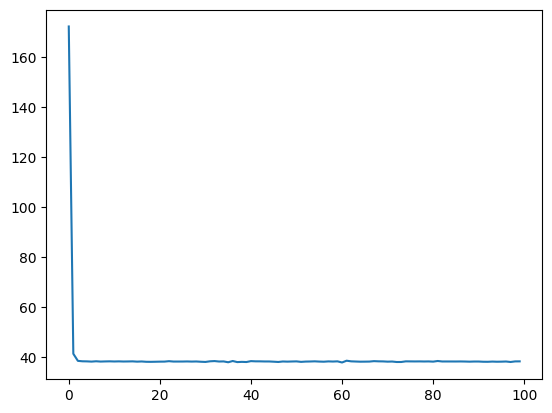

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
# MSE 계산
test_mse = 0 # MSE 계산을 위한 초기화
with torch.no_grad():
    for xx, yy in trainloader:
        yhat = model(xx) # 모델로 예측값 계산
        test_mse += criterion(yhat, yy).item() # 현재 미니배치에 대한 MSE 누적
test_mse /= len(trainloader) # 미니배치 평균으로 MSE 계산

print(test_mse)

37.63704173141755


(b) Using pytorch and customized layer, calculate the train MSE of the following model:

`medv ~ age + lstat + lstat**2`


In [ ]:
# 변수 설정
design = MS(['lstat', 'age'])
X = design.fit_transform(Boston)
y = Boston['medv']

# 표준화
lstat_mean = np.mean(X["lstat"])
lstat_std = np.std(X["lstat"])
lstatsq_mean = np.mean(X["lstat"]**2)
lstatsq_std = np.std(X["lstat"]**2)
age_mean = np.mean(X["age"])
age_std = np.std(X["age"])
# 표준화된 데이터 생성
X1 = torch.tensor((X["age"]- age_mean) / age_std, dtype=torch.float32)
X2 = torch.tensor((X["lstat"]- lstat_mean) / lstat_std, dtype=torch.float32)
X3 = torch.tensor((X["lstat"]**2- lstatsq_mean) / lstatsq_std, dtype=torch.float32)
# 세 표준화된 특성을 하나의 변수로 결합
X_2var_multreg = torch.stack([X1, X2,X3], axis=1)

In [ ]:
X_2var_multreg # 세 개의 특성이 하나로 잘 결합되었음을 알 수 있다

tensor([[-0.1200, -1.0756, -0.7895],
        [ 0.3672, -0.4924, -0.5405],
        [-0.2658, -1.2087, -0.8258],
        ...,
        [ 0.7974, -0.9830, -0.7598],
        [ 0.7370, -0.8653, -0.7166],
        [ 0.4347, -0.6691, -0.6314]])

In [ ]:
X_2var # X_2var과 비교

tensor([[-0.1200, -1.0756],
        [ 0.3672, -0.4924],
        [-0.2658, -1.2087],
        ...,
        [ 0.7974, -0.9830],
        [ 0.7370, -0.8653],
        [ 0.4347, -0.6691]])

In [ ]:
dataset = TensorDataset(X_2var_multreg, Y)
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)

In [ ]:
model = torch.nn.Linear(3, 1, bias = True) # 3(age, lstat, lstat**2)
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01)

# 학습 설정
epochs = 100
n = len(X_2var)
history = []

for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        # model로 yhat 만들기
        yhat = model(xx)

        #loss 계산
        loss = criterion(yhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)

        # loss 이용해 weight update할 grad 생성
        loss.backward()

        my_optim.step()  # 모델 가중치 업데이트
        my_optim.zero_grad() # 그래디언트 초기화

    history.append(LOSS_sum.item() / n) # 학습 결과 저장

100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


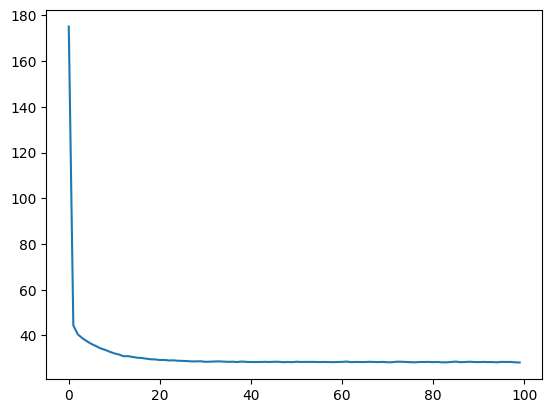

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
# 모델을 사용하여 예측을 생성하고 MSE를 계산
test_mse = 0
with torch.no_grad():
    for xx, yy in trainloader:
        yhat = model(xx)
        test_mse += criterion(yhat, yy).item()

# 테스트 데이터에 대한 MSE를 미니배치 수로 나누어 평균 계산
test_mse /= len(trainloader)

print(test_mse)

28.387755561184857


(c) Using pytorch and customized layer, calculate $R^2$ of each model in (a) and (b).


In [ ]:
## model (a)로 초기화

design = MS(['lstat', 'age'])
X = design.fit_transform(Boston)
y = Boston['medv']
lstat_mean = np.mean(X["lstat"])
lstat_std = np.std(X["lstat"])
age_mean = np.mean(X["age"])
age_std = np.std(X["age"])
X1 = torch.tensor((X["age"]- age_mean) / age_std , dtype=torch.float32)
X2 = torch.tensor((X["lstat"]- lstat_mean) / lstat_std, dtype=torch.float32)
X_2var = torch.stack([X1, X2], axis=1)
Y = torch.tensor(y).reshape(-1,1)
dataset = TensorDataset(X_2var, Y)
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)
model = torch.nn.Linear(2,1, bias = True)
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01)

epochs = 100
n = len(X_2var)
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()
    history.append(LOSS_sum.item()/n)

100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


In [ ]:
# model (a) r2 계산
yhat = model(X_2var)
r2_value = r2(Y, yhat) # 앞서 만들었던 r2 함수 사용
print(f"R2 (Model a): {r2_value.item()}")

R2 (Model a): 0.5498396132242647


In [ ]:
## model (b)로 초기화
design = MS(['lstat', 'age'])
X = design.fit_transform(Boston)
y = Boston['medv']

lstat_mean = np.mean(X["lstat"])
lstat_std = np.std(X["lstat"])
lstatsq_mean = np.mean(X["lstat"]**2)
lstatsq_std = np.std(X["lstat"]**2)
age_mean = np.mean(X["age"])
age_std = np.std(X["age"])
X1 = torch.tensor((X["age"]- age_mean) / age_std, dtype=torch.float32)
X2 = torch.tensor((X["lstat"]- lstat_mean) / lstat_std, dtype=torch.float32)
X3 = torch.tensor((X["lstat"]**2- lstatsq_mean) / lstatsq_std, dtype=torch.float32)
X_2var_multreg = torch.stack([X1, X2,X3], axis=1)

model = torch.nn.Linear(3,1, bias = True)
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01)
dataset = TensorDataset(X_2var_multreg, Y)
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)

epochs = 100
n = len(X_2var)
history = []

for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()
    history.append(LOSS_sum.item() / n)

100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


In [ ]:
# model (b) r2 계산
yhat = model(X_2var_multreg)
r2_value = r2(Y, yhat) # 앞서 만들어두었던 r2 함수 사용
print(f"R2 (Model b): {r2_value.item()}")

R2 (Model b): 0.6678626304180926



(d) Repeat (a) and (b) by making use of 70% of data as train set and the remaining 30% as test set.


In [ ]:
## Repeat (a) by making use of 70% of data as train set and the remaining 30% as test set
dataset = TensorDataset(X_2var,Y) # 데이터셋 생성: X_2var와 Y를 하나의 데이터셋으로 합침
n = len(X) # 전체 데이터 샘플 수
# 데이터를 학습용(train_set)과 검증용(val_set)으로 분할, 70%는 학습용, 30%는 검증용
train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])
# 학습 데이터로 사용할 DataLoader 설정: 미니배치 학습용
trainloader = DataLoader(dataset = train_set, batch_size = 5, shuffle = True)
# 테스트 데이터로 사용할 DataLoader 설정: 검증 데이터, 전체 데이터를 한 번에 처리
testloader =  DataLoader(dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [ ]:
## 다시 만든 데이터로 model(a) 학습
model = torch.nn.Linear( 2,1, bias = True)
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01)
epochs = 100
n = len(X_2var)
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()
    history.append(LOSS_sum.item()/n)

100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


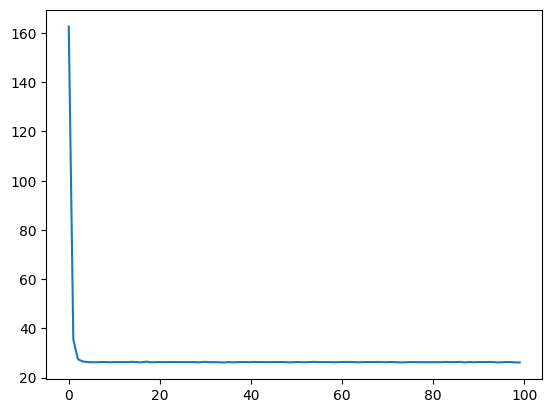

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
# testloader로 예측값 생성
# 원랜 for문을 돌릴필요가 없이 model에 넣고 싶지만 data split시 어떤 데이터가 train으로, test로 간 지 알 수 없어 x,y뽑아내기 위해 for문으로 작성함.
for x, y in testloader:
    yhat = model(x)

In [ ]:
print(yhat[:5])
y[:5]

tensor([[30.4702],
        [18.4716],
        [17.8989],
        [24.2453],
        [15.3198]], grad_fn=<SliceBackward0>)


tensor([[35.4000],
        [13.5000],
        [14.5000],
        [24.7000],
        [13.5000]], dtype=torch.float64)

In [ ]:
print(criterion(yhat, y)) # test mse값 계산

tensor(40.3901, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
## Repeat (b) by making use of 70% of data as train set and the remaining 30% as test set
dataset = TensorDataset(X_2var_multreg,Y)
n = len(X) # 전체 데이터 샘플 수
# 데이터를 학습용(train_set)과 검증용(val_set)으로 분할, 70%는 학습용, 30%는 검증용
train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])
# 학습 데이터로 사용할 DataLoader 설정: 미니배치 학습용
trainloader = DataLoader(dataset = train_set, batch_size = 5, shuffle = True)
# 테스트 데이터로 사용할 DataLoader 설정: 검증 데이터, 전체 데이터를 한 번에 처리
testloader =  DataLoader(dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [ ]:
## 다시 만든 데이터로 model (b) 학습
model = torch.nn.Linear(3,1, bias = True)
my_optim = torch.optim.SGD(model.parameters(), lr = 0.01)
epochs = 100
n = len(X_2var)
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()

    history.append(LOSS_sum.item()/n)

100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


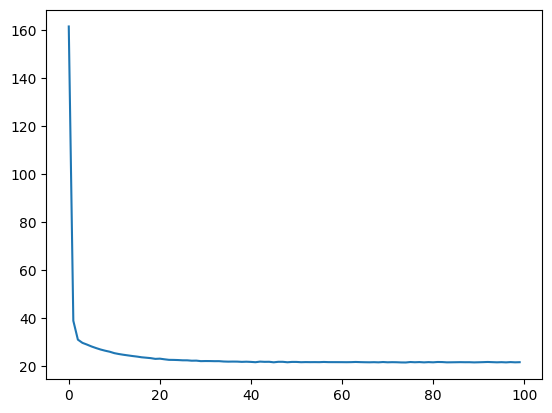

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
# testloader로 예측값 생성
for x, y in testloader:
    yhat = model(x)

In [ ]:
print(yhat[:5])
y[:5]

tensor([[26.3393],
        [22.2819],
        [30.9096],
        [34.8736],
        [18.0902]], grad_fn=<SliceBackward0>)


tensor([[25.0000],
        [18.2000],
        [33.2000],
        [50.0000],
        [23.3000]], dtype=torch.float64)

In [ ]:
print(criterion(yhat, y)) # test mse값 계산

tensor(22.5304, dtype=torch.float64, grad_fn=<MeanBackward0>)


## 3.1 Exercise:

Using `Carseats` data answer the following questions.



In [ ]:
# 데이터 로드
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [ ]:
Carseats.head(5) # 데이터가 잘 들어왔다

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [ ]:
my_vars = list(Carseats.columns.drop('Sales')) # 'Sales' 열을 제외한 모든 열을 선택
y = Carseats['Sales']
X_Carseats = MS(["Advertising", "ShelveLoc"]).fit_transform(Carseats)  # 'Advertising' 및 'ShelveLoc' 열을 선택하고 변환
X_Carseats

,intercept,Advertising,ShelveLoc[Good],ShelveLoc[Medium]
0,1.0,11,0.0,0.0
1,1.0,16,1.0,0.0
2,1.0,10,0.0,1.0
3,1.0,4,0.0,1.0
4,1.0,3,0.0,0.0
...,...,...,...,...
395,1.0,17,1.0,0.0
396,1.0,3,0.0,1.0
397,1.0,12,0.0,1.0
398,1.0,7,0.0,0.0


In [ ]:
# Advertising의 평균과 표준편차 계산
adv_mean = np.mean(X_Carseats["Advertising"])
adv_std = np.std(X_Carseats["Advertising"])

# Advertising 표준화
X_Carseats["Advertising"] = (X_Carseats["Advertising"]- adv_mean) / adv_std

(a) Using pytorch, calculate the train MSE of the following model:

`Sales ~ Advertising + ShelveLoc`


In [ ]:
# Advertising, ShelveLoc[Good], ShelveLoc[Medium]을 PyTorch Tensor로 변환하여 결합
X_Ex3_1 = torch.stack([torch.tensor(X_Carseats['Advertising'], dtype = torch.float32),
            torch.tensor(X_Carseats['ShelveLoc[Good]'], dtype = torch.float32),
            torch.tensor(X_Carseats['ShelveLoc[Medium]'], dtype = torch.float32)], axis = 1)

print(X_Ex3_1[:5]) # 변환된 데이터 중 첫 5개 데이터 출력
Y_1 = torch.tensor(Carseats['Sales'], dtype = torch.float32).reshape(-1,1) # Sales 열을 PyTorch Tensor로 변환하고 모양 재조정

tensor([[ 0.6572,  0.0000,  0.0000],
        [ 1.4100,  1.0000,  0.0000],
        [ 0.5066,  0.0000,  1.0000],
        [-0.3967,  0.0000,  1.0000],
        [-0.5473,  0.0000,  0.0000]])


In [ ]:
dataset = TensorDataset(X_Ex3_1,Y_1) # 데이터셋 생성: X_Ex3_1, Y_1을 결합
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True) # 데이터로더 생성: 미니배치 학습용

In [ ]:
import torch.nn as nn
# Define the model
model = nn.Linear(3, 1, bias=True) # 모델 정의: 입력 특성 수는 3, 출력은 1

my_optim = torch.optim.SGD(model.parameters(), lr=0.01) # 최적화기 및 학습률 설정: SGD
epochs = 100
n = len(trainloader)  # 데이터 로더의 미니배치 수 (적절한 값으로 대체해야 함)
# 손실 함수 정의: MSE 손실 함수
criterion = nn.MSELoss()
history = [] # history값 저장

for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader: # Forward pass
        yhat = model(xx)

        # Loss 계산
        loss = criterion(yhat, yy)
        LOSS_sum += loss.item()

        # 역전파와 그래디언트 업데이트
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()

    history.append(LOSS_sum / n)  # training loss 저장

100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


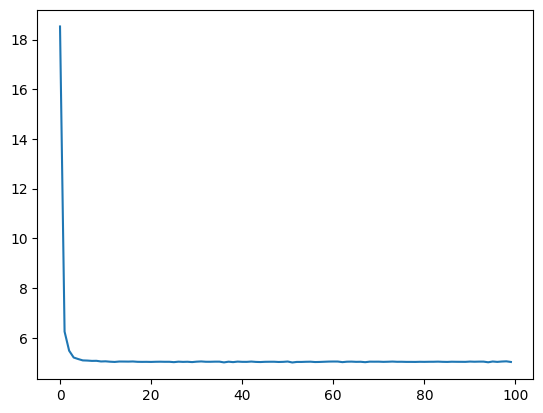

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
## MSE 계산
with torch.no_grad():
    total_mse = 0
    for xx, yy in trainloader:
        # Forward 방식 사용
        yhat = model(xx)
        # 미니배치에 대한 MSE 계산
        mse = criterion(yhat, yy)
        total_mse += mse.item() * len(yy)
    final_mse = total_mse / n # 모든 미니배치에 대한 MSE를 총 샘플 수로 나누어 최종 MSE 계산

print(final_mse)

24.936042986810207



(b) Using pytorch, calculate the train MSE of the following model:

`Sales ~ Advertising`


In [ ]:
## 데이터 조정
X_Ex3_2 = torch.tensor(X_Carseats['Advertising'], dtype = torch.float32).reshape(-1,1)
Y_2 = torch.tensor(Carseats['Sales'], dtype = torch.float32).reshape(-1,1)

In [ ]:
## 데이터 합치기
dataset = TensorDataset(X_Ex3_2,Y_2)
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)

In [ ]:
# 모델 정의
model = nn.Linear(1, 1)  # Advertising & Sales
criterion = nn.MSELoss() # 손실 함수 정의: MSE
optimizer = optim.SGD(model.parameters(), lr=0.01) # optimizer: SGD

# PyTorch 데이터셋 및 데이터 로더 생성
dataset = TensorDataset(X_Ex3_2, Y_2)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True) # 미니배치 학습용 데이터 로더 생성

# 학습 조건 설정
epochs = 100
n = len(X)
history = []

for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader: # 미니배치로 계산
        yhat = model(xx)

        # 손실 계산
        loss = criterion(yhat, yy)
        LOSS_sum += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    history.append(LOSS_sum / n)  # history 저장

100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


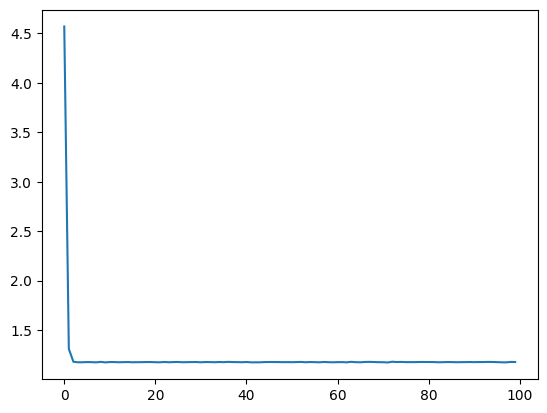

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
## MSE 계산
yhat = model(X_Ex3_2)
train_mse = criterion(yhat, Y_2).item()
print(f"Train MSE: {train_mse}")

Train MSE: 7.380057334899902



(c) Calculate $R^2$ of each model in (a) and (b).


In [ ]:
## model (a)
# model (a)로 초기화
X_Ex3_1 = torch.stack([torch.tensor(X_Carseats['Advertising'], dtype = torch.float32),
            torch.tensor(X_Carseats['ShelveLoc[Good]'], dtype = torch.float32),
            torch.tensor(X_Carseats['ShelveLoc[Medium]'], dtype = torch.float32)], axis = 1)
Y_1 = torch.tensor(Carseats['Sales'], dtype = torch.float32).reshape(-1,1)
dataset = TensorDataset(X_Ex3_1,Y_1)
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)
model = nn.Linear(3, 1, bias=True)
my_optim = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 100
n = len(trainloader)
criterion = nn.MSELoss()
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        # Forward pass
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum += loss.item()
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()
    history.append(LOSS_sum / n)

100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


In [ ]:
# model (a) r2 계산
yhat_1 = model(X_Ex3_1)
r2_value = r2(Y_1, yhat_1) # 앞서 만들었던 r2 함수 사용
print(f"R2 (Model a): {r2_value.item()}")

R2 (Model a): 0.3715518116950989


In [ ]:
## model (b)
# model (b)로 초기화
X_Ex3_2 = torch.tensor(X_Carseats['Advertising'], dtype = torch.float32).reshape(-1,1)
Y_2 = torch.tensor(Carseats['Sales'], dtype = torch.float32).reshape(-1,1)
dataset = TensorDataset(X_Ex3_2,Y_2)
trainloader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)
model = nn.Linear(1, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
dataset = TensorDataset(X_Ex3_2, Y_2)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)
epochs = 100
n = len(X)
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    history.append(LOSS_sum / n)

100%|██████████| 100/100 [00:06<00:00, 15.31it/s]


In [ ]:
# model (b) r2 계산
yhat_2 = model(X_Ex3_2)
r2_value = r2(Y_2, yhat_2) # 앞서 만들었던 r2 함수 사용
print(f"R2 (Model b): {r2_value.item()}")

R2 (Model b): 0.07254457473754883



(d) Repeat (a) and (b) by making use of 70% of data as train set and the remaining 30% as test set.

In [ ]:
## (a)
# 70% of data as train set and the remaining 30% as test set
dataset = TensorDataset(X_Ex3_1,Y_1)
n = len(X_Carseats)
# 70%의 데이터를 훈련 세트로, 나머지 30%를 테스트 세트로 나눔
train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])
# 훈련 데이터 로더 생성: 미니배치 학습용, 미니배치 크기는 5
trainloader = DataLoader( dataset = train_set, batch_size = 5, shuffle = True)
# 테스트 데이터 로더 생성: 전체 테스트 세트를 하나의 미니배치로 사용
testloader =  DataLoader( dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [ ]:
## model (a) 다시 학습시키기
model = nn.Linear(3, 1, bias=True)
my_optim = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 100
n = len(trainloader)
criterion = nn.MSELoss()
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum += loss.item()
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()
    history.append(LOSS_sum / n)

100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


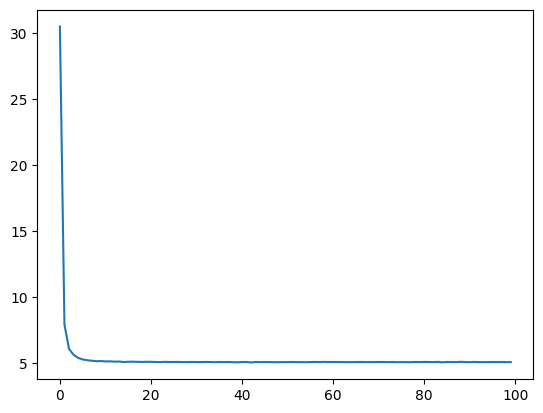

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
## MSE 계산
with torch.no_grad():
    total_mse = 0
    for xx, yy in trainloader:
        # Forward 방식 사용
        yhat = model(xx)
        # 미니배치에 대한 MSE 계산
        mse = criterion(yhat, yy)
        total_mse += mse.item() * len(yy)
    final_mse = total_mse / n # 모든 미니배치에 대한 MSE를 총 샘플 수로 나누어 최종 MSE 계산

print(final_mse)

25.295619099800074


In [ ]:
## (b)
# 70% of data as train set and the remaining 30% as test set
dataset = TensorDataset(X_Ex3_2,Y_2)
n = len(X_Carseats)
# 70%의 데이터를 훈련 세트로, 나머지 30%를 테스트 세트로 나눔
train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])
# 훈련 데이터 로더 생성: 미니배치 학습용, 미니배치 크기는 5
trainloader = DataLoader(dataset = train_set, batch_size = 5, shuffle = True)
# 테스트 데이터 로더 생성: 전체 테스트 세트를 하나의 미니배치로 사용
testloader =  DataLoader(dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [ ]:
# model(b) 다시 학습시키기
model = nn.Linear(1, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
dataset = TensorDataset(X_Ex3_2, Y_2)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)
epochs = 100
n = len(X)
history = []
for _ in tqdm(range(epochs)):
    LOSS_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        LOSS_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    history.append(LOSS_sum / n)

100%|██████████| 100/100 [00:04<00:00, 24.18it/s]


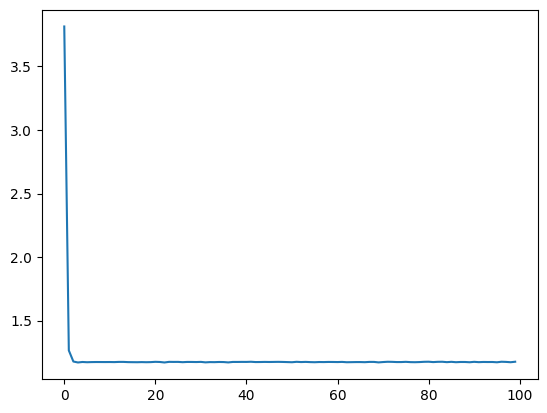

In [ ]:
plt.plot(history) # 학습 과정에서 기록된 손실 값을 시각화

In [ ]:
## MSE 계산
yhat = model(X_Ex3_2)
train_mse = criterion(yhat, Y_2).item()
print(f"Train MSE: {train_mse}")

Train MSE: 7.380727767944336
